<h1>Model definition and training</h1>
Here we are using SARIMAX model. The hyperparameters used here are arbitrary. Hence consider changing them after understanding the meaning of the hyper-parameters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../datasets/train-processed.csv')
df.head()

,industry-coal,industry-natural_gas,industry-oil,other-oil,transport-natural_gas,transport-oil
0,190.50,11.37,531.26,587.72,0.43,1588.61
1,280.42,7.11,408.65,535.58,0.43,1428.29
2,143.21,8.36,444.82,584.31,0.43,1581.16
3,186.45,6.72,433.29,565.79,0.43,1557.40
4,273.05,9.45,495.61,563.24,0.43,1513.35


In [3]:
import statsmodels.api as sm

preds = []
for column_name in df.columns:
    # fit
    model = sm.tsa.statespace.SARIMAX(df[column_name],
                                      trend          = "c",
                                      order          = (2,1,0),
                                      seasonal_order = (1,1,1,12))
    model_fit = model.fit()
    
    # predict
    pred = model_fit.predict(start = 0,
                             end   = 419 + 12).to_list()
    preds.append(pred)
    
preds = pd.DataFrame(np.array(preds).T, columns = df.columns)

c:\Users\User\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h1>Submission</h1>
Here we convert the predicted value to the submission format.

In [4]:
# generate a series of timestamps at 1-m intervals between start_time and end_time
preds["time"] = pd.date_range(start = pd.to_datetime("1987-01-01 00:00:00"),
                              end   = pd.to_datetime("2022-12-01 00:00:00"),
                              freq  = "MS")


#melt to match with the submission format
preds = pd.melt(preds, id_vars = "time", var_name='source_fueltype', value_name='emissions_tons')

# split "source_fueltype" to "source" amd "fuel_type"
preds[["source", "fuel_type"]] = preds["source_fueltype"].str.split("-", expand=True)

# split "time" to "year, month"
preds["year"] = preds["time"].dt.year
preds["month"] = preds["time"].dt.month

del preds["time"]

Let's compare the result of the predicted value with the ground-truth before submitting

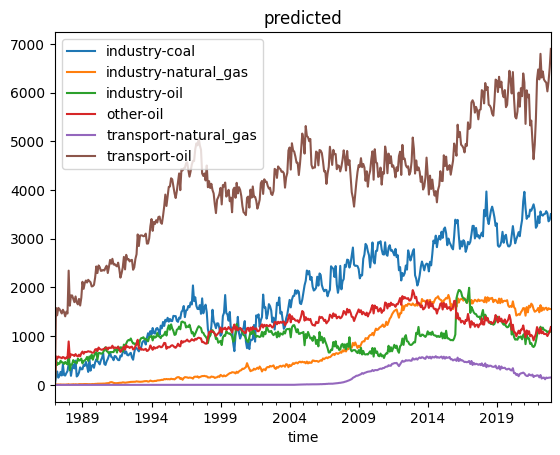

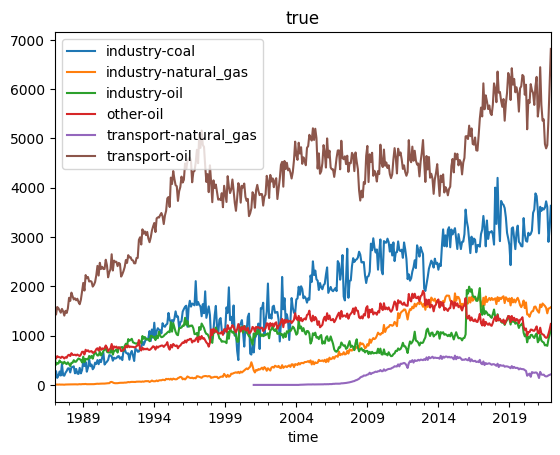

In [5]:
# visualize the predictted
preds["time"] = preds.apply(lambda row : pd.to_datetime(str(row["year"]) + " " + str(row["month"])), axis = 1)
preds["source_fueltype"] = preds[["source", "fuel_type"]].apply("-".join, axis=1)
preds.set_index('time', inplace=True)
preds.groupby('source_fueltype')["emissions_tons"].plot(title = "predicted", legend=True)
plt.show()

# visualize the true
train = pd.read_csv("../datasets/train.csv")
train["time"] = train.apply(lambda row : pd.to_datetime(str(row["year"]) + " " + str(row["month"])), axis = 1)
train["source_fueltype"] = train[["source", "fuel_type"]].apply("-".join, axis=1)
train.set_index('time', inplace=True)
train.groupby('source_fueltype')["emissions_tons"].plot(title = "true", legend=True)
plt.show()

In [6]:
del preds["source_fueltype"]

submission = pd.merge(preds, pd.read_csv("../datasets/test.csv"),
                      how = "inner",
                      on  = ["year", "month", "source", "fuel_type"])

submission.to_csv("../result/submission.csv", index=False)